# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:

import statsmodels.api as sm
from datetime import date

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [8]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

# The Data

In [9]:
wfc = pd.read_csv('Dataset/WFC Daily1.csv')

In [10]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [11]:
wfc.Date.dtype

dtype('O')

In [12]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [13]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [14]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5754 non-null   datetime64[ns]
 1   Open       5754 non-null   float64       
 2   High       5754 non-null   float64       
 3   Low        5754 non-null   float64       
 4   Close      5754 non-null   float64       
 5   Adj Close  5754 non-null   float64       
 6   Volume     5754 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


In [15]:
wfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,36.78,35.98,36.38,28.01,24313450.19
std,11.74,11.77,11.73,11.75,12.85,26705062.78
min,8.65,8.94,7.80,8.12,5.76,1774000.00
25%,26.71,27.20,26.25,26.74,18.01,10091200.00
50%,32.65,33.13,32.25,32.64,23.18,17086600.00
75%,47.75,48.19,47.33,47.79,41.58,29145250.00
max,65.89,66.31,65.66,65.93,57.96,478736600.00


In [16]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999324,0.999274,0.998754,0.965403,-0.184389
High,0.999324,1.000000,0.998796,0.999323,0.967945,-0.169457
Low,0.999274,0.998796,1.000000,0.999303,0.963519,-0.199335
Close,0.998754,0.999323,0.999303,1.000000,0.966149,-0.183272
Adj Close,0.965403,0.967945,0.963519,0.966149,1.000000,-0.080189
Volume,-0.184389,-0.169457,-0.199335,-0.183272,-0.080189,1.000000


# The Split

In [17]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [18]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [19]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [20]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 7)
Train dataset shape: (4313, 7)
Vaid dataset shape: (692, 7)
Test dataset shape: (749, 7)


# Stock Price Graph

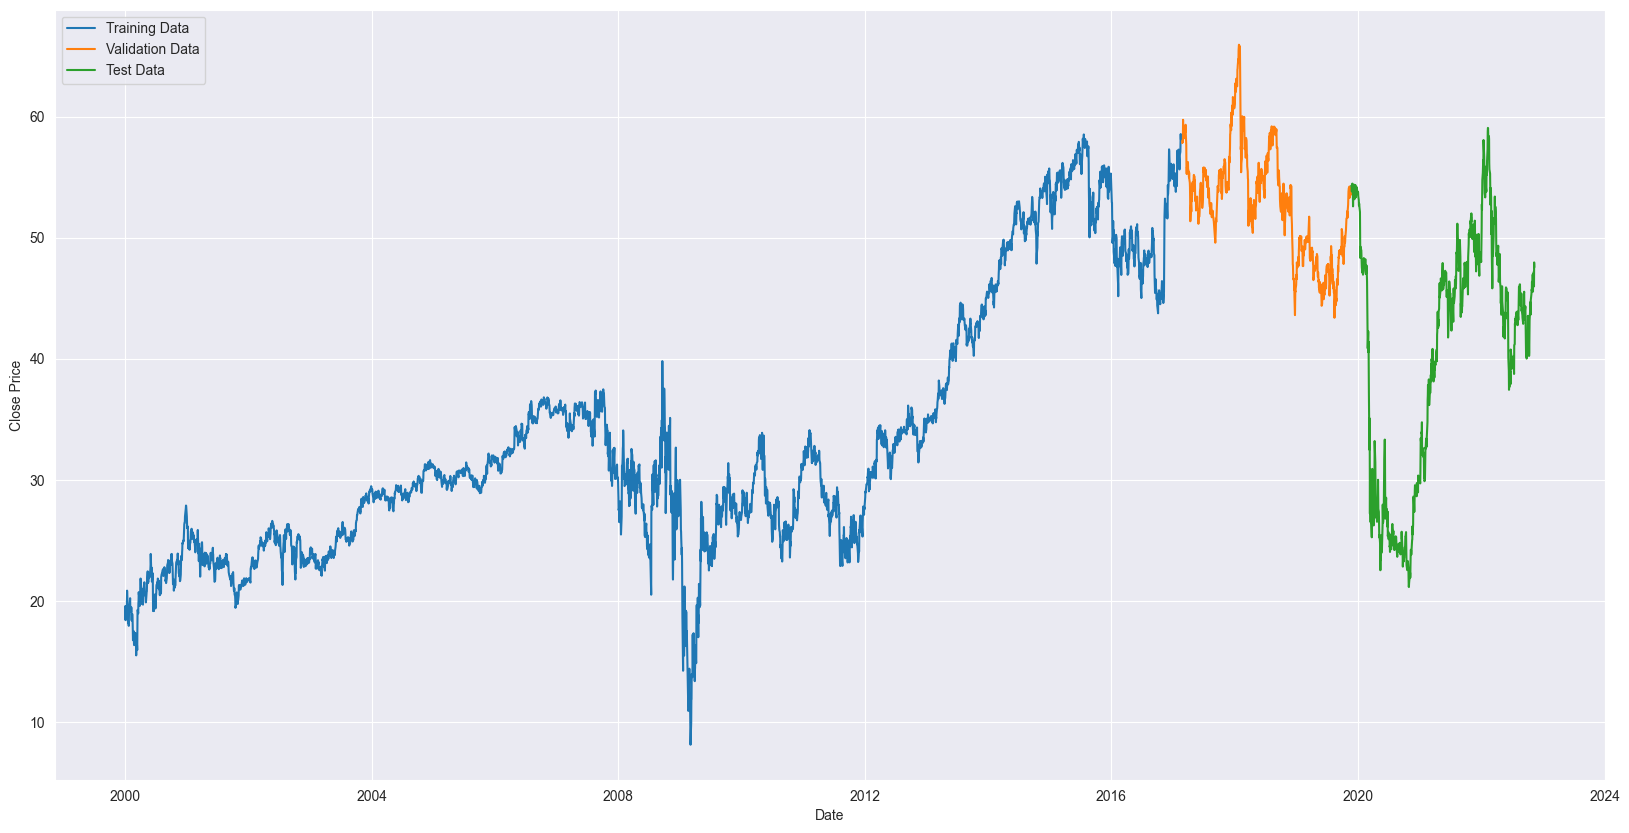

In [21]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

In [22]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [23]:
trainNorm = train_df.Close.values.reshape(-1, 1)
testNorm = test_df.Close.values.reshape(-1, 1)
validNorm = valid_df.Close.values.reshape(-1, 1)

In [24]:
trainNorm.shape

(4313, 1)

## Windowed Dataset

In [25]:
mse_arr=[]
Z = []

window = 15

In [26]:
X_train= []
Y_train=[]
X_valid= []
Y_valid=[]
X_test= []
Y_test=[]

for i in range(len(trainNorm) - (window)):
    X_train.append(trainNorm[i:i+window])
    Y_train.append(trainNorm[i+window])
    
for i in range(len(validNorm) - (window)):
    X_valid.append(validNorm[i:i+window])
    Y_valid.append(validNorm[i+window])
    
for i in range(len(testNorm) - (window)):
    X_test.append(testNorm[i:i+window])
    Y_test.append(testNorm[i+window])
    

X_train=np.asanyarray(X_train)
Y_train=np.asanyarray(Y_train)
X_valid=np.asanyarray(X_valid)
Y_valid=np.asanyarray(Y_valid)
X_test=np.asanyarray(X_test)
Y_test=np.asanyarray(Y_test)

Xtrain = X_train[:,:,:]  
Ytrain = Y_train[:]  
Xvalid = X_valid[:,:,:]  
Yvalid= Y_valid[:]  
Xtest = X_test[:,:,:]  
Ytest= Y_test[:]  

# Model Building

In [27]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [28]:
model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(keras.layers.Dense(1))

In [29]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [30]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer = Adam(1e-8),
             metrics = ["mae"])

In [31]:
history = model.fit(Xtrain,Ytrain,batch_size=128, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
34/34 [==============================] - 16s 31ms/step - loss: 1210.3953 - mae: 33.2396 - lr: 1.0000e-08
Epoch 2/500
34/34 [==============================] - 1s 25ms/step - loss: 1210.3881 - mae: 33.2395 - lr: 1.1220e-08
Epoch 3/500
34/34 [==============================] - 1s 25ms/step - loss: 1210.3781 - mae: 33.2394 - lr: 1.2589e-08
Epoch 4/500
34/34 [==============================] - 1s 24ms/step - loss: 1210.3683 - mae: 33.2392 - lr: 1.4125e-08
Epoch 5/500
34/34 [==============================] - 1s 25ms/step - loss: 1210.3596 - mae: 33.2391 - lr: 1.5849e-08
Epoch 6/500
34/34 [==============================] - 1s 24ms/step - loss: 1210.3490 - mae: 33.2389 - lr: 1.7783e-08
Epoch 7/500
34/34 [==============================] - 1s 24ms/step - loss: 1210.3396 - mae: 33.2388 - lr: 1.9953e-08
Epoch 8/500
34/34 [==============================] - 1s 24ms/step - loss: 1210.3258 - mae: 33.2386 - lr: 2.2387e-08
Epoch 9/500
34/34 [==============================] - 1s 24ms/step - los

34/34 [==============================] - 1s 24ms/step - loss: 827.9886 - mae: 26.8720 - lr: 3.1623e-05
Epoch 72/500
34/34 [==============================] - 1s 25ms/step - loss: 799.6263 - mae: 26.3408 - lr: 3.5481e-05
Epoch 73/500
34/34 [==============================] - 1s 24ms/step - loss: 772.2211 - mae: 25.8169 - lr: 3.9811e-05
Epoch 74/500
34/34 [==============================] - 1s 24ms/step - loss: 744.5969 - mae: 25.2759 - lr: 4.4668e-05
Epoch 75/500
34/34 [==============================] - 1s 24ms/step - loss: 716.6218 - mae: 24.7154 - lr: 5.0119e-05
Epoch 76/500
34/34 [==============================] - 1s 24ms/step - loss: 689.0162 - mae: 24.1515 - lr: 5.6234e-05
Epoch 77/500
34/34 [==============================] - 1s 24ms/step - loss: 662.4641 - mae: 23.5929 - lr: 6.3096e-05
Epoch 78/500
34/34 [==============================] - 1s 24ms/step - loss: 637.0532 - mae: 23.0491 - lr: 7.0795e-05
Epoch 79/500
34/34 [==============================] - 1s 24ms/step - loss: 612.7245 -

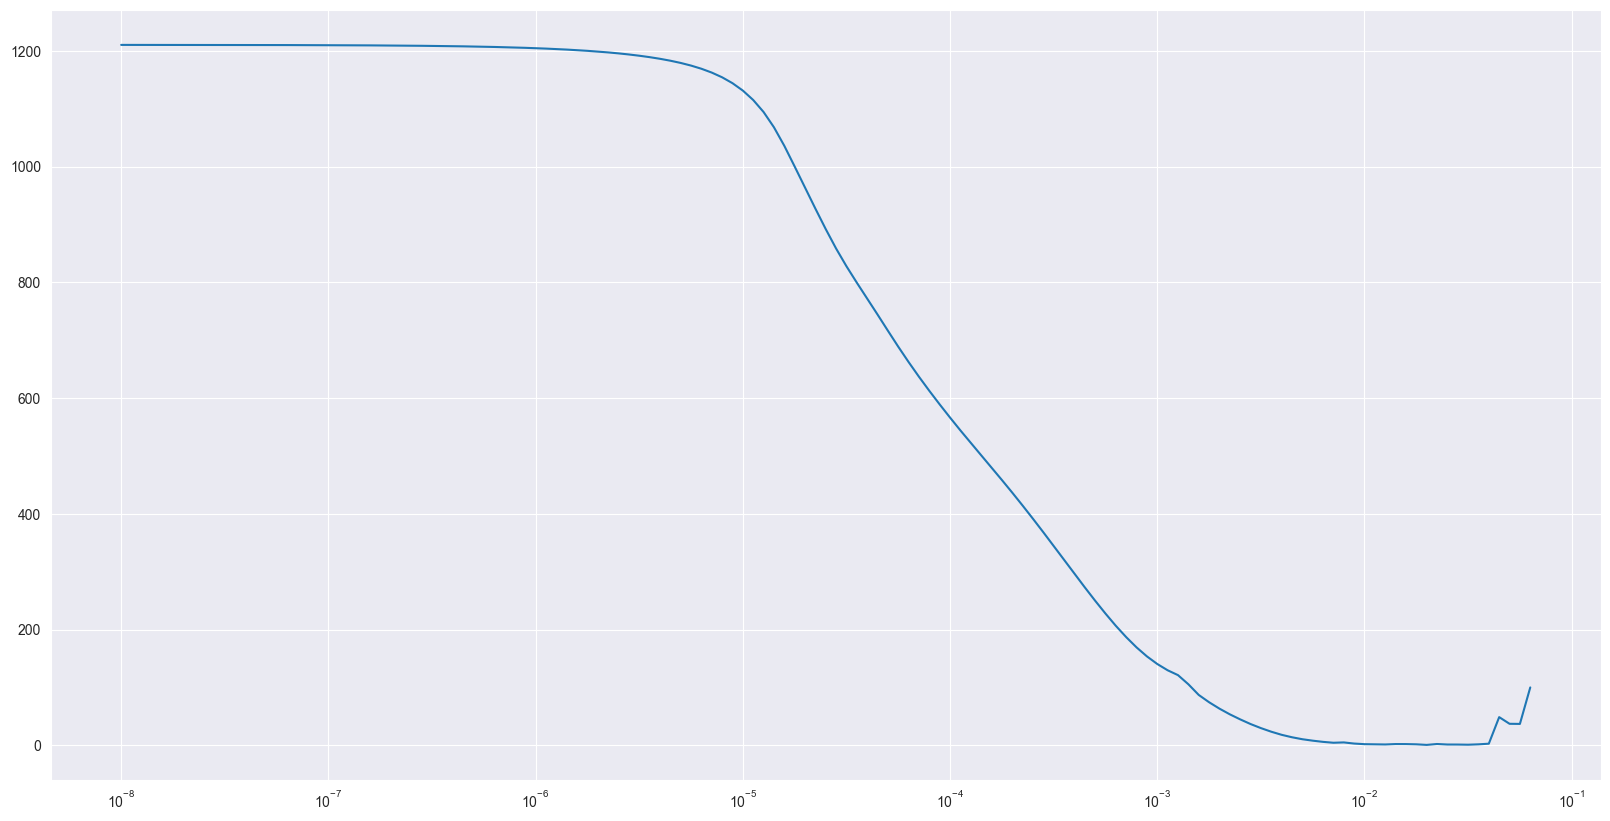

In [32]:
# plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 30])

(0.001, 0.1, 0.0, 25.0)

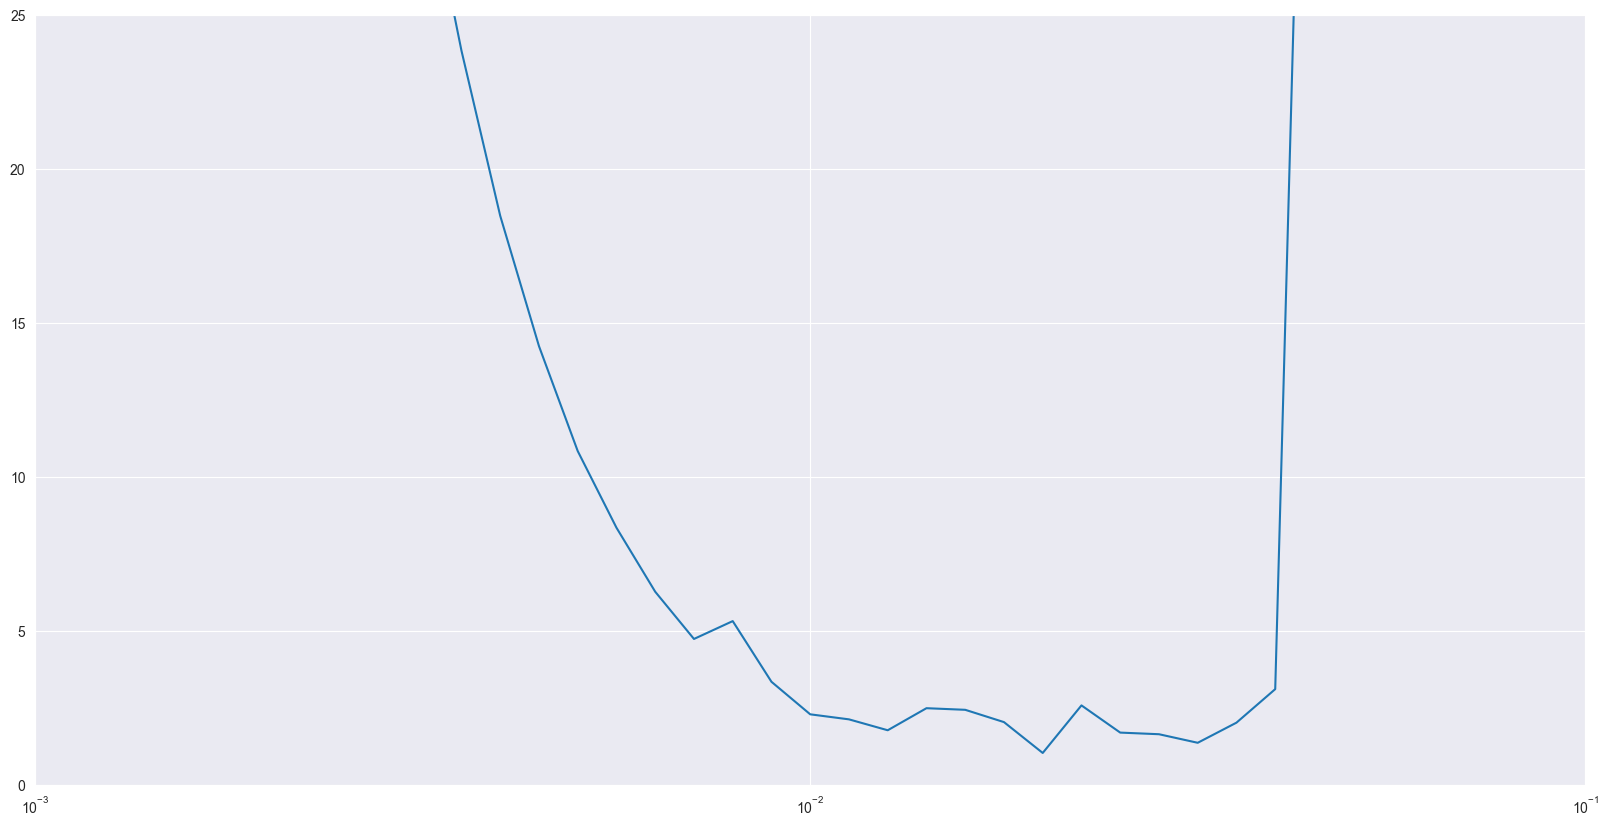

In [34]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-1, 0, 25])